In [1]:
import nba_api
import requests

import pandas as pd
import matplotlib.pyplot as plt

import time

In [2]:
from sklearn.decomposition import PCA

In [3]:
#this api has the data I need but it's game-by-game data, not season data.
# https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/boxscoremiscv3.md

#from nba_api.stats.endpoints import boxscoremiscv3
#bs = boxscoremiscv3.BoxScoreMiscV3()

In [4]:
from nba_api.stats.endpoints import teamestimatedmetrics

team estimated metrics is some good stuff, but doesn't include advanced defensive statistics

In [5]:
tem = teamestimatedmetrics.TeamEstimatedMetrics()

In [6]:
tem_df = tem.get_data_frames()[0]

In [7]:
tem_df.loc[tem_df.TEAM_NAME == "Oklahoma City Thunder"]

,TEAM_NAME,TEAM_ID,GP,W,L,W_PCT,MIN,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,...,MIN_RANK,E_OFF_RATING_RANK,E_DEF_RATING_RANK,E_NET_RATING_RANK,E_AST_RATIO_RANK,E_OREB_PCT_RANK,E_DREB_PCT_RANK,E_REB_PCT_RANK,E_TM_TOV_PCT_RANK,E_PACE_RANK
5,Oklahoma City Thunder,1610612760,14,13,1,0.929,692.0,116.6,101.9,14.7,...,1,5,1,1,19,23,2,10,2,25


In [8]:

## this API doesn't work anymore, apparently
# from nba_api.stats.endpoints import defensehub

# dh = defensehub.DefenseHub(season="2024-25")

so now we have to play everybody's favorite screen scraping game, reverse engineering some AJAX requests to get what we want.

this is the page I'm trying to scrape data out of: https://www.nba.com/stats/teams/defense?Season=2024-25&dir=A&sort=DEF_RATING

this is the request for the data I want

```
curl.exe ^"https://stats.nba.com/stats/leaguedashteamstats?Conference=^&DateFrom=^&DateTo=^&Division=^&GameScope=^&GameSegment=^&Height=^&ISTRound=^&LastNGames=0^&LeagueID=00^&Location=^&MeasureType=Defense^&Month=0^&OpponentTeamID=0^&Outcome=^&PORound=0^&PaceAdjust=N^&PerMode=PerGame^&Period=0^&PlayerExperience=^&PlayerPosition=^&PlusMinus=N^&Rank=N^&Season=2024-25^&SeasonSegment=^&SeasonType=Regular^%^20Season^&ShotClockRange=^&StarterBench=^&TeamID=0^&TwoWay=0^&VsConference=^&VsDivision=^" ^
  --compressed ^
  -H ^"User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:145.0) Gecko/20100101 Firefox/145.0^" ^
  -H ^"Accept: */*^" ^
  -H ^"Accept-Language: en-US,en;q=0.5^" ^
  -H ^"Accept-Encoding: gzip, deflate, br, zstd^" ^
  -H ^"Referer: https://www.nba.com/^" ^
  -H ^"Origin: https://www.nba.com^" ^
  -H ^"Sec-GPC: 1^" ^
  -H ^"Connection: keep-alive^" ^
  -H ^"Sec-Fetch-Dest: empty^" ^
  -H ^"Sec-Fetch-Mode: cors^" ^
  -H ^"Sec-Fetch-Site: same-site^" ^
  -H ^"Priority: u=4^"
  ```

note `PerMode=Per100Possessions`



https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Defense&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Per100Possessions&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2010-11&SeasonSegment=&SeasonType=Regular%20Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=

https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2024-25&SeasonSegment=&SeasonType=Regular%20Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=

changing 'MeasureType' to 'Misc' or 'Opponent' will get some more columns.

In [9]:
def url_for_season(season="2025-26"):

    url_template = "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=" + \
    "&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Defense&Month=0" + \
    "&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Per100Possessions&Period=0&PlayerExperience=&" + \
    "PlayerPosition=&PlusMinus=N&Rank=N&Season=%(season)s&SeasonSegment=&SeasonType=Regular Season" + \
    "&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision="

    the_url = url_template % {'season' : season}
    return the_url

had to add some headers to keep the request getting blocked:

In [ ]:
headers = {
    'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:145.0) Gecko/20100101 Firefox/145.0",
    'Referer' : "https://www.nba.com",
    'Origin'  : "https://www.nba.com",
    "Sec-GPC" : "1",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-site"
}

def nba_scrape_request(season="2025-26"):
    the_url = url_for_season(season)
    r = requests.get(the_url, headers=headers)
    req_json =  r.json()['resultSets'][0]
    df = pd.DataFrame(req_json['rowSet'], columns=req_json['headers'])
    return df

In [ ]:
def fetch_seasons(start_year=15, end_year=26):
    years = [x for x in range(start_year, end_year)]

    dataframes = []
    for year in years:
        year_param = "20%d-%d" % (year, year+1)
        df = nba_scrape_request(year_param)
        df['SEASON'] = year
        dataframes.append(df)
        print(f"did {year_param}")
        time.sleep(2)

    df = pd.concat(dataframes, ignore_index=True)
    return df

nba doesn't have per-100 stats before 2010


In [12]:
last15 = fetch_seasons(10,26)


did 2010-11
did 2011-12
did 2012-13
did 2013-14
did 2014-15
did 2015-16
did 2016-17
did 2017-18
did 2018-19
did 2019-20
did 2020-21
did 2021-22
did 2022-23
did 2023-24
did 2024-25
did 2025-26


In [13]:
last15

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,DEF_RATING_RANK,DREB_RANK,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,SEASON
0,1610612737,Atlanta Hawks,82,44,38,0.537,53.3,105.8,33.2,0.710,...,14,13,10,29,24,17,19,22,18,10
1,1610612738,Boston Celtics,82,56,26,0.683,52.7,99.8,33.9,0.709,...,2,6,11,3,25,10,10,2,3,10
2,1610612766,Charlotte Bobcats,82,34,48,0.415,53.2,107.0,32.8,0.705,...,17,15,12,27,6,25,16,23,15,10
3,1610612741,Chicago Bulls,82,62,20,0.756,52.6,99.5,35.2,0.717,...,1,3,3,14,4,14,3,12,2,10
4,1610612739,Cleveland Cavaliers,82,19,63,0.232,51.2,110.9,31.7,0.699,...,29,21,16,26,29,16,14,20,19,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1610612758,Sacramento Kings,13,3,10,0.231,46.6,120.5,29.5,0.692,...,27,26,15,17,28,17,18,20,27,25
476,1610612759,San Antonio Spurs,12,8,4,0.667,47.8,111.5,33.7,0.713,...,6,4,6,13,7,21,8,2,2,25
477,1610612761,Toronto Raptors,13,8,5,0.615,47.1,113.4,31.7,0.686,...,13,17,16,19,20,5,20,4,19,25
478,1610612762,Utah Jazz,12,4,8,0.333,47.0,118.3,32.3,0.700,...,25,11,11,27,26,24,17,13,8,25


In [14]:
last15.corr(numeric_only=True)['W_PCT']

TEAM_ID                   -0.158390
GP                         0.013343
W                          0.771066
L                         -0.760943
W_PCT                      1.000000
MIN                        0.048617
DEF_RATING                -0.466067
DREB                       0.482923
DREB_PCT                   0.217669
STL                        0.247231
BLK                        0.259631
OPP_PTS_OFF_TOV           -0.455147
OPP_PTS_2ND_CHANCE        -0.200829
OPP_PTS_FB                -0.344207
OPP_PTS_PAINT             -0.377758
GP_RANK                   -0.084320
W_RANK                    -0.966055
L_RANK                    -0.966692
W_PCT_RANK                -0.967943
MIN_RANK                  -0.093248
DEF_RATING_RANK           -0.736637
DREB_RANK                 -0.525960
DREB_PCT_RANK             -0.286853
STL_RANK                  -0.245564
BLK_RANK                  -0.238458
OPP_PTS_OFF_TOV_RANK      -0.495379
OPP_PTS_2ND_CHANCE_RANK   -0.233152
OPP_PTS_FB_RANK           -0

In [15]:
last15.iloc[0]

TEAM_ID                       1610612737
TEAM_NAME                  Atlanta Hawks
GP                                    82
W                                     44
L                                     38
W_PCT                              0.537
MIN                                 53.3
DEF_RATING                         105.8
DREB                                33.2
DREB_PCT                            0.71
STL                                  6.7
BLK                                  4.6
OPP_PTS_OFF_TOV                     16.9
OPP_PTS_2ND_CHANCE                  14.1
OPP_PTS_FB                          15.7
OPP_PTS_PAINT                       44.8
GP_RANK                                1
W_RANK                                13
L_RANK                                13
W_PCT_RANK                            13
MIN_RANK                               4
DEF_RATING_RANK                       14
DREB_RANK                             13
DREB_PCT_RANK                         10
STL_RANK        

In [16]:
last15.OPP_PTS_PAINT.describe()

count    480.000000
mean      46.497708
std        3.582026
min       36.100000
25%       43.900000
50%       46.450000
75%       48.900000
max       58.500000
Name: OPP_PTS_PAINT, dtype: float64

In [17]:
last15.loc[last15.OPP_PTS_PAINT.idxmin()]

TEAM_ID                               1610612760
TEAM_NAME                  Oklahoma City Thunder
GP                                            14
W                                             13
L                                              1
W_PCT                                      0.929
MIN                                         48.1
DEF_RATING                                 102.8
DREB                                        36.0
DREB_PCT                                   0.717
STL                                         10.4
BLK                                          5.1
OPP_PTS_OFF_TOV                             15.1
OPP_PTS_2ND_CHANCE                          12.4
OPP_PTS_FB                                   9.9
OPP_PTS_PAINT                               36.1
GP_RANK                                        1
W_RANK                                         1
L_RANK                                         1
W_PCT_RANK                                     1
MIN_RANK            

In [18]:
last15.loc[69]

TEAM_ID                               1610612744
TEAM_NAME                  Golden State Warriors
GP                                            82
W                                             47
L                                             35
W_PCT                                      0.573
MIN                                         50.2
DEF_RATING                                 104.2
DREB                                        35.5
DREB_PCT                                   0.712
STL                                          7.2
BLK                                          4.4
OPP_PTS_OFF_TOV                             17.9
OPP_PTS_2ND_CHANCE                          14.4
OPP_PTS_FB                                  14.3
OPP_PTS_PAINT                               42.0
GP_RANK                                        1
W_RANK                                        10
L_RANK                                        10
W_PCT_RANK                                    10
MIN_RANK            

how has defensive rating changed over the past 10 years?

In [19]:
last15.groupby('SEASON')['DEF_RATING'].mean()

SEASON
10    106.276667
11    103.493333
12    104.766667
13    105.690000
14    104.746667
15    105.536667
16    108.143333
17    107.840000
18    109.730000
19    110.153333
20    111.696667
21    111.360000
22    114.070000
23    114.516667
24    113.683333
25    114.723333
Name: DEF_RATING, dtype: float64

I'd like to visualize all these teams in an easy to understand way... I'm going to use 2D PCA.

It's kind of a cliche to have the scatterplot with one crazy outlier. but the classics are the classics because people like them

In [20]:
last15.columns

Index(['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'DEF_RATING',
       'DREB', 'DREB_PCT', 'STL', 'BLK', 'OPP_PTS_OFF_TOV',
       'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT', 'GP_RANK',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'DEF_RATING_RANK',
       'DREB_RANK', 'DREB_PCT_RANK', 'STL_RANK', 'BLK_RANK',
       'OPP_PTS_OFF_TOV_RANK', 'OPP_PTS_2ND_CHANCE_RANK', 'OPP_PTS_FB_RANK',
       'OPP_PTS_PAINT_RANK', 'SEASON'],
      dtype='object')

In [21]:
cols_for_training = ['DEF_RATING', 'DREB', 'DREB_PCT', 'STL', 'BLK', 'OPP_PTS_OFF_TOV',
                    'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT']

rank_cols = [ 'DREB_PCT_RANK','STL_RANK', 'BLK_RANK',
       'OPP_PTS_OFF_TOV_RANK', 'OPP_PTS_2ND_CHANCE_RANK', 'OPP_PTS_FB_RANK',
       'OPP_PTS_PAINT_RANK'] # omitting 'DEF_RATING_RANK' because it is redundant (in theory, with PCA)

last15[rank_cols]

,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK
0,10,29,24,17,19,22,18
1,11,3,25,10,10,2,3
2,12,27,6,25,16,23,15
3,3,14,4,14,3,12,2
4,16,26,29,16,14,20,19
...,...,...,...,...,...,...,...
475,15,17,28,17,18,20,27
476,6,13,7,21,8,2,2
477,16,19,20,5,20,4,19
478,11,27,26,24,17,13,8


In [22]:
model = PCA(n_components=2, whiten=True)

train_data = last15[rank_cols] # rank might be fairer

X_reduced = model.fit_transform(train_data)

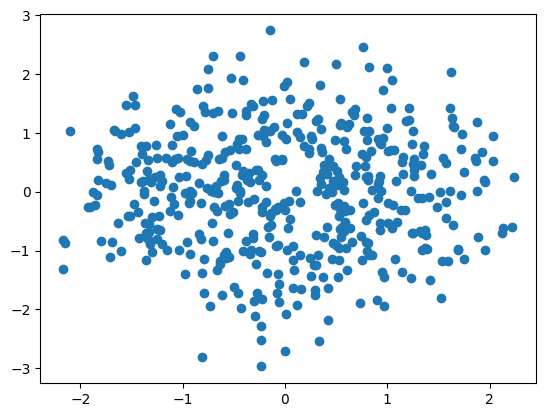

In [23]:
plt.scatter(X_reduced[:,0],X_reduced[:,1])

In [24]:
last15['PCA_1'] = X_reduced[:,0]
last15['PCA_2'] = X_reduced[:,1]

In [25]:
this_season = last15.loc[(last15.SEASON==25)].copy()

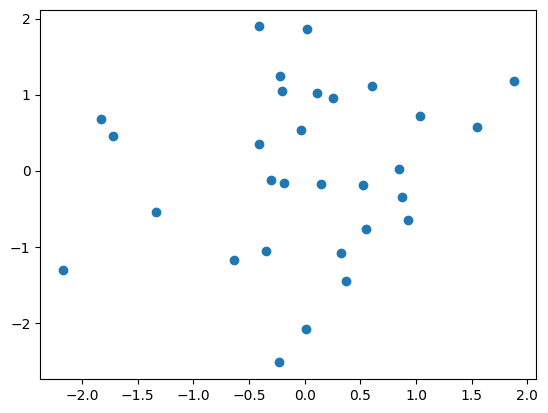

In [26]:
plt.scatter(this_season.PCA_1, this_season.PCA_2)

In [27]:
this_season.loc[this_season.TEAM_NAME == "Oklahoma City Thunder"]

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,SEASON,PCA_1,PCA_2
470,1610612760,Oklahoma City Thunder,14,13,1,0.929,48.1,102.8,36.0,0.717,...,5,1,13,2,2,1,1,25,-2.171896,-1.309403


In [28]:
this_season.loc[this_season.PCA_1 < -1]

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,SEASON,PCA_1,PCA_2
457,1610612743,Denver Nuggets,12,10,2,0.833,47.6,109.4,35.2,0.731,...,4,21,23,3,1,3,11,25,-1.826300,0.677007
469,1610612752,New York Knicks,12,8,4,0.667,47.8,114.3,31.9,0.735,...,2,15,24,7,4,9,5,25,-1.721238,0.459707
470,1610612760,Oklahoma City Thunder,14,13,1,0.929,48.1,102.8,36.0,0.717,...,5,1,13,2,2,1,1,25,-2.171896,-1.309403
476,1610612759,San Antonio Spurs,12,8,4,0.667,47.8,111.5,33.7,0.713,...,6,13,7,21,8,2,2,25,-1.333468,-0.541188


ok, what about collapsing it all down to one number?

where does OKC's defensive ranking match up with teams over the past 5 seasons?

In [29]:
model = PCA(n_components=1, whiten=True)

train_data = last15[rank_cols] # rank might be fairer

X_reduced_1d = model.fit_transform(train_data)

In [30]:
train_data


,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK
0,10,29,24,17,19,22,18
1,11,3,25,10,10,2,3
2,12,27,6,25,16,23,15
3,3,14,4,14,3,12,2
4,16,26,29,16,14,20,19
...,...,...,...,...,...,...,...
475,15,17,28,17,18,20,27
476,6,13,7,21,8,2,2
477,16,19,20,5,20,4,19
478,11,27,26,24,17,13,8


In [31]:
pca_1d = pd.Series(X_reduced_1d[:,0])

In [32]:
last15['PCA_1D'] = pca_1d

In [33]:
last15.PCA_1D.describe()

count    4.800000e+02
mean    -2.400857e-16
std      1.000000e+00
min     -2.171896e+00
25%     -7.513678e-01
50%     -3.029450e-02
75%      7.860749e-01
max      2.236227e+00
Name: PCA_1D, dtype: float64

In [34]:
last15.loc[last15.PCA_1D.idxmin()]

TEAM_ID                               1610612760
TEAM_NAME                  Oklahoma City Thunder
GP                                            14
W                                             13
L                                              1
W_PCT                                      0.929
MIN                                         48.1
DEF_RATING                                 102.8
DREB                                        36.0
DREB_PCT                                   0.717
STL                                         10.4
BLK                                          5.1
OPP_PTS_OFF_TOV                             15.1
OPP_PTS_2ND_CHANCE                          12.4
OPP_PTS_FB                                   9.9
OPP_PTS_PAINT                               36.1
GP_RANK                                        1
W_RANK                                         1
L_RANK                                         1
W_PCT_RANK                                     1
MIN_RANK            

the thunder have been in the top 3 in 6/10 previous seasons on opponent fast break points

In [35]:
last15[last15.OPP_PTS_FB_RANK <= 3].groupby('TEAM_NAME')['TEAM_NAME'].count()

TEAM_NAME
Atlanta Hawks            1
Boston Celtics           3
Brooklyn Nets            1
Charlotte Bobcats        1
Charlotte Hornets        2
Cleveland Cavaliers      1
Denver Nuggets           3
Detroit Pistons          4
Houston Rockets          1
Indiana Pacers           4
Los Angeles Clippers     1
Miami Heat               4
Milwaukee Bucks          3
Oklahoma City Thunder    6
Orlando Magic            3
Philadelphia 76ers       2
Sacramento Kings         3
San Antonio Spurs        1
Utah Jazz                2
Washington Wizards       2
Name: TEAM_NAME, dtype: int64

In [36]:
last15[last15.OPP_PTS_PAINT_RANK <= 3].groupby('TEAM_NAME')['TEAM_NAME'].count()

TEAM_NAME
Atlanta Hawks             1
Boston Celtics            3
Charlotte Hornets         1
Chicago Bulls             4
Denver Nuggets            1
Detroit Pistons           2
Golden State Warriors     1
Indiana Pacers            4
Los Angeles Clippers      2
Memphis Grizzlies         4
Miami Heat                4
Milwaukee Bucks           4
Minnesota Timberwolves    1
New York Knicks           1
Oklahoma City Thunder     4
Orlando Magic             1
Philadelphia 76ers        2
Portland Trail Blazers    1
San Antonio Spurs         1
Toronto Raptors           2
Utah Jazz                 1
Washington Wizards        3
Name: TEAM_NAME, dtype: int64

what about just summing the ranks up?

In [37]:
rank_cols

['DREB_PCT_RANK',
 'STL_RANK',
 'BLK_RANK',
 'OPP_PTS_OFF_TOV_RANK',
 'OPP_PTS_2ND_CHANCE_RANK',
 'OPP_PTS_FB_RANK',
 'OPP_PTS_PAINT_RANK']

In [38]:
rank_cols2 = [ 'OPP_PTS_OFF_TOV_RANK',
 'OPP_PTS_2ND_CHANCE_RANK',
 'OPP_PTS_FB_RANK',
 'OPP_PTS_PAINT_RANK']

last15['rank_sum2'] = last15[rank_cols2].T.sum()

In [39]:
last15['rank_sum'] = last15[rank_cols].T.sum()

In [40]:
last15.rank_sum2.describe()

count    480.000000
mean      62.000000
std       24.011219
min        6.000000
25%       43.000000
50%       62.000000
75%       80.000000
max      116.000000
Name: rank_sum2, dtype: float64

In [41]:
last15.loc[last15.rank_sum2 < 15]

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,SEASON,PCA_1,PCA_2,PCA_1D,rank_sum2,rank_sum
52,1610612755,Philadelphia 76ers,66,35,31,0.530,52.9,98.2,35.6,0.712,...,1,2,1,2,11,-2.154004,-0.873314,-2.154004,6,33
101,1610612754,Indiana Pacers,82,56,26,0.683,51.7,98.9,37.0,0.721,...,6,2,3,1,13,-1.921242,-0.267342,-1.921242,12,48
188,1610612765,Detroit Pistons,82,37,45,0.451,50.2,106.7,36.0,0.775,...,1,1,3,8,16,-2.103056,1.038661,-2.103056,13,66
256,1610612749,Milwaukee Bucks,82,60,22,0.732,46.4,104.9,38.9,0.757,...,2,4,1,1,18,-2.171840,-0.815235,-2.171840,8,31
470,1610612760,Oklahoma City Thunder,14,13,1,0.929,48.1,102.8,36.0,0.717,...,2,2,1,1,25,-2.171896,-1.309403,-2.171896,6,25


<Axes: >

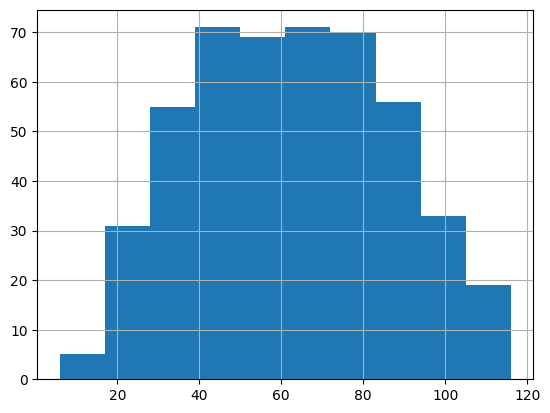

In [42]:
last15.rank_sum2.hist()

In [43]:
last15.rank_sum.describe()

count    480.000000
mean     108.500000
std       32.975223
min       25.000000
25%       82.750000
50%      107.500000
75%      133.000000
max      187.000000
Name: rank_sum, dtype: float64

In [56]:
last15.sort_values('rank_sum')[-10:]

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,SEASON,PCA_1,PCA_2,PCA_1D,rank_sum2,rank_sum
7,1610612765,Detroit Pistons,82,30,52,0.366,53.5,110.7,30.1,0.681,...,23,30,26,29,10,1.860762,0.566659,1.860762,108,175
85,1610612758,Sacramento Kings,82,28,54,0.341,50.8,110.0,30.6,0.673,...,25,25,30,25,12,1.866504,0.518648,1.866504,105,175
163,1610612747,Los Angeles Lakers,82,17,65,0.207,49.8,110.3,33.4,0.712,...,20,29,30,29,15,1.735669,0.977369,1.735669,108,175
47,1610612751,New Jersey Nets,66,22,44,0.333,52.7,108.1,31.1,0.677,...,26,22,26,28,11,1.652314,1.101864,1.652314,102,176
414,1610612757,Portland Trail Blazers,82,21,61,0.256,49.1,116.6,30.5,0.697,...,29,24,29,28,23,1.924433,0.684285,1.924433,110,176
103,1610612747,Los Angeles Lakers,82,27,55,0.329,48.2,109.3,32.0,0.676,...,26,30,29,29,13,2.236227,0.253084,2.236227,114,177
386,1610612759,San Antonio Spurs,82,22,60,0.268,47.0,119.6,31.0,0.709,...,28,23,23,30,22,1.617661,1.417138,1.617661,104,178
340,1610612745,Houston Rockets,82,20,62,0.244,47.5,116.4,32.0,0.710,...,30,26,30,30,21,2.037244,0.955186,2.037244,116,180
448,1610612762,Utah Jazz,82,17,65,0.207,47.6,119.4,32.9,0.705,...,30,27,30,27,24,1.623929,2.037882,1.623929,114,186
452,1610612751,Brooklyn Nets,12,1,11,0.083,49.0,125.3,27.2,0.625,...,18,26,29,30,25,1.876459,1.178770,1.876459,103,187


In [45]:
last15.iloc[52]

TEAM_ID                            1610612755
TEAM_NAME                  Philadelphia 76ers
GP                                         66
W                                          35
L                                          31
W_PCT                                    0.53
MIN                                      52.9
DEF_RATING                               98.2
DREB                                     35.6
DREB_PCT                                0.712
STL                                       8.7
BLK                                       5.7
OPP_PTS_OFF_TOV                          12.7
OPP_PTS_2ND_CHANCE                       12.8
OPP_PTS_FB                               11.2
OPP_PTS_PAINT                            39.9
GP_RANK                                     1
W_RANK                                     16
L_RANK                                     16
W_PCT_RANK                                 16
MIN_RANK                                    7
DEF_RATING_RANK                   

<Axes: >

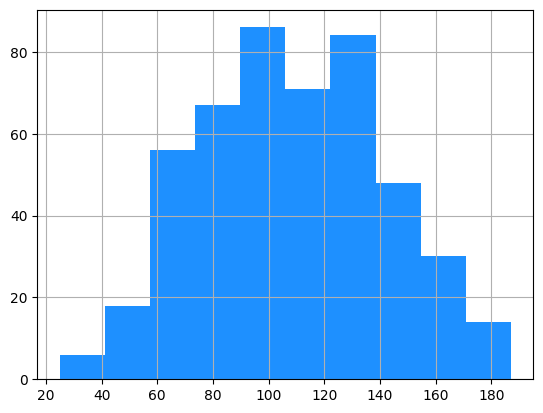

In [46]:
last15.rank_sum.hist(color='dodgerblue')

<Axes: >

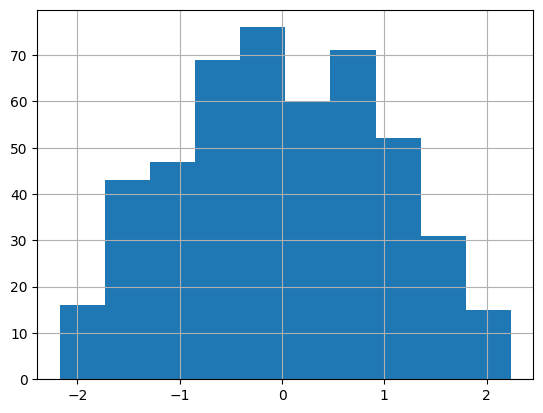

In [47]:
last15.PCA_1D.hist()

In [62]:
6/11

0.5454545454545454

In [48]:
last15.loc[last15.rank_sum.idxmin()]

TEAM_ID                               1610612760
TEAM_NAME                  Oklahoma City Thunder
GP                                            14
W                                             13
L                                              1
W_PCT                                      0.929
MIN                                         48.1
DEF_RATING                                 102.8
DREB                                        36.0
DREB_PCT                                   0.717
STL                                         10.4
BLK                                          5.1
OPP_PTS_OFF_TOV                             15.1
OPP_PTS_2ND_CHANCE                          12.4
OPP_PTS_FB                                   9.9
OPP_PTS_PAINT                               36.1
GP_RANK                                        1
W_RANK                                         1
L_RANK                                         1
W_PCT_RANK                                     1
MIN_RANK            

defensive rating is a better predictor of win percentage than my attempts (`PCA_2`, `rank_sum`)

In [49]:
last15.corr(numeric_only=True)['W_PCT']

TEAM_ID                   -0.158390
GP                         0.013343
W                          0.771066
L                         -0.760943
W_PCT                      1.000000
MIN                        0.048617
DEF_RATING                -0.466067
DREB                       0.482923
DREB_PCT                   0.217669
STL                        0.247231
BLK                        0.259631
OPP_PTS_OFF_TOV           -0.455147
OPP_PTS_2ND_CHANCE        -0.200829
OPP_PTS_FB                -0.344207
OPP_PTS_PAINT             -0.377758
GP_RANK                   -0.084320
W_RANK                    -0.966055
L_RANK                    -0.966692
W_PCT_RANK                -0.967943
MIN_RANK                  -0.093248
DEF_RATING_RANK           -0.736637
DREB_RANK                 -0.525960
DREB_PCT_RANK             -0.286853
STL_RANK                  -0.245564
BLK_RANK                  -0.238458
OPP_PTS_OFF_TOV_RANK      -0.495379
OPP_PTS_2ND_CHANCE_RANK   -0.233152
OPP_PTS_FB_RANK           -0

misc stuff just for the blog


jokic


In [60]:
.448 / .250

1.792

In [59]:
5.376 / 20

0.26880000000000004

In [61]:
12 * ( 1/ 1.792)

6.696428571428571